In [ ]:
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import matplotlib.pyplot as plt
#from keras_preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

def ebdist(leye,reye):
    eyedist = dist.euclidean(leye,reye)
    points.append(int(eyedist))
    return eyedist

#calculating lip dostance using facial landmark
def lpdist(l_lower,l_upper):
    lipdist = dist.euclidean(l_lower, l_upper)
    points_lip.append(int(lipdist))
    return lipdist

#finding stressed or not using the emotions 
def emotion_finder(faces,frame):
    EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
    x,y,w,h = face_utils.rect_to_bb(faces)
    frame = frame[y:y+h,x:x+w]
    roi = cv2.resize(frame,(64,64))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi,axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    if label in ['scared','sad','angry']:
        label = 'Stressed'
    else:
        label = 'Not Stressed'
    return label

#calculating stress value using the distances
def normalize_values(points,disp,points_lip,dis_lip):
    normalize_value_lip = abs(dis_lip - np.min(points_lip))/abs(np.max(points_lip) - np.min(points_lip))
    normalized_value_eye =abs(disp - np.min(points))/abs(np.max(points) - np.min(points))
    normalized_value =( normalized_value_eye + normalize_value_lip)/2
    stress_value = (np.exp(-(normalized_value)))
    if stress_value>=0.65:
        stress_label="High Stress"
    else:
        stress_label="Low Stress"
    return stress_value,stress_label
global points, points_lip, emotion_classifier, detector, predictor

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
cap = cv2.VideoCapture(0)
points = []; points_lip=[]
n=int(input())
if(n==1):
    while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)
            frame = imutils.resize(frame, width=500,height=500)
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow)
                leyebrowhull = cv2.convexHull(leyebrow)
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                lipdist = lpdist(openmouthhull[-1],openmouthhull[0])
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
    
                stress_value,stress_label = normalize_values(points,eyedist, points_lip, lipdist)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
def plt_show():
        plot_stress=plt.plot(range(len(points)),points,'ro')
        plt.title("Stress Levels")
        plt.show()
        return plot_stress
    
cv2.destroyAllWindows()
cap.release()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import io
import time
# Camera stream
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1280)
cap.set(cv2.CAP_PROP_FPS, 30)
# Video stream (optional, not tested)
# cap = cv2.VideoCapture("video.mp4")
# Image crop
x, y, w, h = 800, 500, 100, 100
x, y, w, h = 950, 300, 100, 100
heartbeat_count = 128
heartbeat_values = [0]*heartbeat_count
heartbeat_times = [time.time()]*heartbeat_count
# Matplotlib graph surface
fig = plt.figure()
ax = fig.add_subplot(111)
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    crop_img = img[y:y + h, x:x + w]
    # Update the data
    heartbeat_values = heartbeat_values[1:] + [np.average(crop_img)]
    heartbeat_times = heartbeat_times[1:] + [time.time()]
    # Draw matplotlib graph to numpy array
    ax.plot(heartbeat_times, heartbeat_values)
    fig.canvas.draw()
    plot_img_np = np.fromstring(fig.canvas.tostring_rgb(),
                                dtype=np.uint8, sep='')
    plot_img_np = plot_img_np.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.cla()
    # Display the frames
    cv2.imshow('crop', crop_img)
    cv2.imshow('Graph', plot_img_np)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
#live video opens
cap = cv2.VideoCapture(0)
points = []; points_lip=[]
while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)#to rotate img along x-axis and y-axis or both
            frame = imutils.resize(frame, width=500,height=500)#imutils - for resizing,translation,rotation and displaying matplotlib imgs
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)#to display emotion
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)#used to convert to numpy array which is used to easily detect the facial landmarks
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow) #eyebrow points are consdered as boundary and points inside form a cluster
                leyebrowhull = cv2.convexHull(leyebrow) #A convex hull encloses a set of points and it acts as a cluster boundary which helps in determining all the points within a cluster.
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1) #the boundary color drawn around the eyebrow
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
                lipdist = lpdist(openmouth[-1],openmouth[0])
    
                stress_value,stress_label = normalize_values(points,eyedist, points_lip, lipdist)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break

1/1 [==============================] - 0s 260ms/step


<ipython-input-1-c25966900055>:45: RuntimeWarning: divide by zero encountered in double_scalars
  normalize_value_lip = abs(dis_lip - np.min(points_lip))/abs(np.max(points_lip) - np.min(points_lip))
<ipython-input-1-c25966900055>:46: RuntimeWarning: invalid value encountered in double_scalars
  normalized_value_eye =abs(disp - np.min(points))/abs(np.max(points) - np.min(points))


ValueError: cannot convert float NaN to integer

<ipython-input-8-0ecbbd7ec40a>:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot_img_np = np.fromstring(fig.canvas.tostring_rgb(),


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


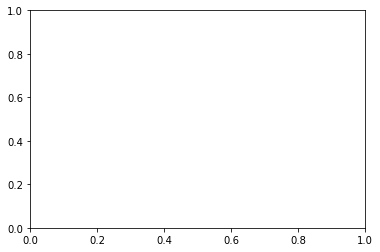

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import io
import time
# Camera stream
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1280)
cap.set(cv2.CAP_PROP_FPS, 30)
# Video stream (optional, not tested)
# cap = cv2.VideoCapture("video.mp4")
# Image crop
x, y, w, h = 800, 500, 100, 100
x, y, w, h = 950, 300, 100, 100
heartbeat_count = 128
heartbeat_values = [0]*heartbeat_count
heartbeat_times = [time.time()]*heartbeat_count
# Matplotlib graph surface
fig = plt.figure()
ax = fig.add_subplot(111)
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    crop_img = img[y:y + h, x:x + w]
    # Update the data
    heartbeat_values = heartbeat_values[1:] + [np.average(crop_img)]
    heartbeat_times = heartbeat_times[1:] + [time.time()]
    # Draw matplotlib graph to numpy array
    ax.plot(heartbeat_times, heartbeat_values)
    fig.canvas.draw()
    plot_img_np = np.fromstring(fig.canvas.tostring_rgb(),
                                dtype=np.uint8, sep='')
    plot_img_np = plot_img_np.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.cla()
    # Display the frames
    cv2.imshow('crop', crop_img)
    cv2.imshow('Graph', plot_img_np)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()